In [10]:
import random
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

# SumTree

In [2]:
class SumTree:
    def __init__(self, size):
        self.nodes = [0] * (2*size - 1)
        self.data = [None] * size
        
        self.size = size
        self.count = 0
        self.real_size = 0
    
    @property
    def total(self):
        return self.nodes[0]
    
    def update(self, data_idx, value):
        idx = data_idx + self.size - 1 # child index in tree array
        change = value - self.nodes[idx]
        
        self.nodes[idx] = value
        
        parent = (idx - 1) // 2
        while parent >= 0:
            self.nodes[parent] += change
            parent = (parent - 1) // 2
    
    def add(self, value, data):        
        self.data[self.count] = data
        self.update(self.count, value)
        
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)
        
    def get(self, cumsum):
        assert cumsum <= self.total
        
        idx = 0
        while 2 * idx + 1 < len(self.nodes):
            left, right = 2*idx + 1, 2*idx + 2
            
            if cumsum <= self.nodes[left]:
                idx = left
            else:
                idx = right
                cumsum = cumsum - self.nodes[left]
                
        data_idx = idx - self.size + 1
            
        return data_idx, self.nodes[idx], self.data[data_idx]
    
    def __repr__(self):
        return f"SumTree(nodes={self.nodes.__repr__()}, data={self.data.__repr__()})"

In [3]:
test_tree = SumTree(size=4)
# test_tree.nodes = [10, 3, 7, 1, 2, 3, 4]
print(test_tree)

test_tree.add(1, "a")
test_tree.add(2, "b")
test_tree.add(3, "v")
test_tree.add(4, "g")

print(test_tree)

test_tree.add(10, "10")
test_tree.add(10, "10")
test_tree.add(10, "100")
test_tree.add(10, "100")

test_tree.update(0, 0)

print(test_tree)

SumTree(nodes=[0, 0, 0, 0, 0, 0, 0], data=[None, None, None, None])
SumTree(nodes=[10, 3, 7, 1, 2, 3, 4], data=['a', 'b', 'v', 'g'])
SumTree(nodes=[30, 10, 20, 0, 10, 10, 10], data=['10', '10', '100', '100'])


# PER

In [4]:
class PrioritizedReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size, eps=1e-2, alpha=0.1, beta=0.1):
        self.tree = SumTree(size=buffer_size)
        
        # PER params
        self.eps = eps
        self.alpha = alpha
        self.beta = beta
        self.max_priority = eps # init as eps
        
        # state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, 1, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, 1, dtype=torch.int)
    
        self.count = 0
        self.real_size = 0
        self.size = buffer_size
    
    def add(self, transition):        
        state, action, reward, next_state, done = transition
        
        # store transition index with priority in sum tree
        self.tree.add(self.max_priority, self.count)
        
        # store transition in the buffer
        self.state[self.count] = torch.as_tensor(state)
        self.action[self.count] = torch.as_tensor(action)
        self.reward[self.count] = torch.as_tensor(reward)
        self.next_state[self.count] = torch.as_tensor(next_state)
        self.done[self.count] = torch.as_tensor(done)
        
        # update counters
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)
        
    def sample(self, batch_size):
        assert self.real_size >= batch_size

        segment = self.tree.total / batch_size
        
        sample_idxs, data_idxs = [], []
        priorities = torch.empty(batch_size, 1, dtype=torch.float)
        
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            
            cumsum = random.uniform(a, b)
            data_idx, priority, sample_idx = self.tree.get(cumsum)
            
            data_idxs.append(data_idx)
            priorities[i] = priority
            sample_idxs.append(sample_idx)
            
        probs = priorities / self.tree.total
        weights = (self.real_size * probs) ** -self.beta
        weights = weights / weights.max()
        
        batch = (
            self.state[sample_idxs], 
            self.action[sample_idxs], 
            self.reward[sample_idxs], 
            self.next_state[sample_idxs],
            self.done[sample_idxs]
        )
        
        return batch, weights, data_idxs
    
    def update_priorities(self, data_idxs, priorities):
        for data_idx, priority in zip(data_idxs, priorities):
            priority = (priority + self.eps) ** self.alpha
            
            self.tree.update(data_idx, priority)
            self.max_priority = max(self.max_priority, priority)

# N-step buffer

In [5]:
class NStepReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size, n_step=1, gamma=0.99):
        # n-step buffer
        self.n_step_buffer = deque(maxlen=n_step)
        self.gamma = gamma
        self.n_step = n_step
        
        # state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, 1, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, 1, dtype=torch.int)
    
        self.count = 0
        self.real_size = 0
        self.size = buffer_size
        
    def add(self, transition):
        self.n_step_buffer.append(transition)
        
        if len(self.n_step_buffer) < self.n_step:
            return
        
        state, action = self.n_step_buffer[0][:2] 
        reward, next_state, done = self.get_n_step_return(self.n_step_buffer, self.gamma)
        
        self.state[self.count] = torch.as_tensor(state, dtype=torch.float)
        self.action[self.count] = torch.as_tensor(action, dtype=torch.float)
        self.reward[self.count] = torch.as_tensor(reward, dtype=torch.float)
        self.next_state[self.count] = torch.as_tensor(next_state, dtype=torch.float)
        self.done[self.count] = torch.as_tensor(done, dtype=torch.float)
        
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)
        
    def get_n_step_return(self, n_step_buffer, gamma):
        n_reward, n_next_state, n_done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            reward, next_state, done = transition[-3:]

            n_reward = reward + gamma * n_reward * (1 - done)

            if done:
                n_next_state, n_done = next_state, done

        return n_reward, n_next_state, n_done

    def sample(self, batch_size):
        assert self.real_size >= batch_size
        
        sample_idxs = np.random.choice(self.real_size, batch_size, replace=False)
        batch = (
            self.state[sample_idxs], 
            self.action[sample_idxs], 
            self.reward[sample_idxs], 
            self.next_state[sample_idxs],
            self.done[sample_idxs]
        )
        return batch

# Different sampling

In [6]:
tree = SumTree(size=1000)

for i in range(1000):
    p = random.uniform(0, 50)
    tree.add(p, p)

In [18]:
def sample_segments(tree, batch_size):
    segment = tree.total / batch_size

    priorities = []
    for i in range(batch_size):
        a, b = segment * i, segment * (i + 1)

        cumsum = random.uniform(a, b)
        data_idx, priority, sample_idx = tree.get(cumsum)

        priorities.append(priority)
        
    return priorities

def sample_cumsum(tree, batch_size):
    cumsums = np.random.uniform(0, tree.total, size=batch_size)

    priorities = []
    for i, cumsum in enumerate(cumsums):
        data_idx, priority, sample_idx = tree.get(cumsum)
        priorities.append(priority)
        
    return priorities

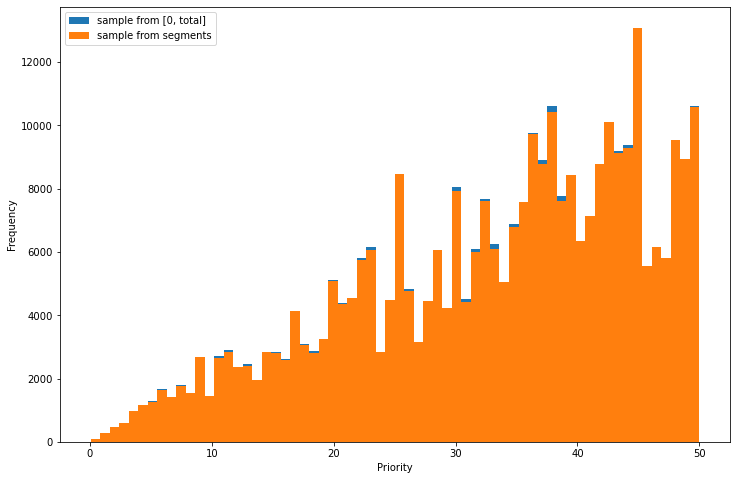

In [32]:
segments = sum([sample_segments(tree, 64) for _ in range(5000)], [])
cumsums = sum([sample_cumsum(tree, 64) for _ in range(5000)], [])

plt.figure(figsize=(12, 8))
plt.hist(cumsums, bins=64, label="sample from [0, total]")
plt.hist(segments, bins=64, label="sample from segments");
plt.legend()
plt.xlabel("Priority")
plt.ylabel("Frequency")
plt.savefig("sampling_approaches.jpg", dpi=200, bbox_inches='tight')

# PER & N-step buffer

In [45]:
class NStepPER:
    def __init__(self, state_size, action_size, buffer_size, n_step=1, gamma=0.99, eps=1e-2, alpha=0.1, beta=0.1):
        self.tree = SumTree(size=buffer_size)
        
        # N step params
        self.gamma = gamma
        self.n_step = n_step
        self.n_step_buffer = deque(maxlen=n_step)
        
        # PER params
        self.eps = eps
        self.alpha = alpha
        self.beta = beta
        self.max_priority = eps # init as eps
        
        # state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, 1, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, 1, dtype=torch.int)
        
        # to save memory if n_step == 1
        if self.n_step > 1:
            self.n_reward = torch.empty(buffer_size, action_size, dtype=torch.float)
            self.n_next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
            self.n_done = torch.empty(buffer_size, 1, dtype=torch.int)
        
        self.count = 0
        self.real_size = 0
        self.size = buffer_size
    
    def add(self, transition):        
        state, action, reward, next_state, done = transition

        if self.n_step > 1:
            self.n_step_buffer.append(transition)
            
            if len(self.n_step_buffer) < self.n_step:
                return

            # get n-step return from last n transitions
            n_reward, n_next_state, n_done = self.get_n_step_return(self.n_step_buffer, self.gamma)
            
            # store n-step info in the buffer
            self.n_reward[self.count] = torch.as_tensor(n_reward)
            self.n_next_state[self.count] = torch.as_tensor(n_next_state)
            self.n_done[self.count] = torch.as_tensor(n_done)
        
        # store transition index with priority in sum tree
        self.tree.add(self.max_priority, self.count)
        
        # store transition in the buffer
        self.state[self.count] = torch.as_tensor(state)
        self.action[self.count] = torch.as_tensor(action)
        self.reward[self.count] = torch.as_tensor(reward)
        self.next_state[self.count] = torch.as_tensor(next_state)
        self.done[self.count] = torch.as_tensor(done)
        
        # update counters
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)
        
    def sample(self, batch_size):
        assert self.real_size >= batch_size

        segment = self.tree.total / batch_size
        
        sample_idxs, data_idxs = [], []
        priorities = torch.empty(batch_size, 1, dtype=torch.float)
        
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            
            cumsum = random.uniform(a, b)
            data_idx, priority, sample_idx = self.tree.get(cumsum)
            
            data_idxs.append(data_idx)
            priorities[i] = priority
            sample_idxs.append(sample_idx)
            
        probs = priorities / self.tree.total
        weights = (self.real_size * probs) ** -self.beta
        weights = weights / weights.max()
        
        batch = (
            self.state[sample_idxs], 
            self.action[sample_idxs], 
            self.reward[sample_idxs], 
            self.next_state[sample_idxs],
            self.done[sample_idxs]
        )
        
        if self.n_step > 1:
            n_step_batch = (
                self.state[sample_idxs],
                self.action[sample_idxs],
                self.n_reward[sample_idxs],
                self.n_next_state[sample_idxs],
                self.n_done[sample_idxs]
            )
            
            return batch, n_step_batch, weights, data_idxs
        
        return batch, weights, data_idxs
    
    def update_priorities(self, data_idxs, priorities):
        for data_idx, priority in zip(data_idxs, priorities):
            priority = (priority + self.eps) ** self.alpha
            
            self.tree.update(data_idx, priority)
            self.max_priority = max(self.max_priority, priority)
                        
    def get_n_step_return(self, n_step_buffer, gamma):
        n_reward, n_next_state, n_done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            reward, next_state, done = transition[-3:]

            n_reward = reward + gamma * n_reward * (1 - done)

            if done:
                n_next_state, n_done = next_state, done

        return n_reward, n_next_state, n_done

In [57]:
buffer = NStepPER(4, 1, buffer_size=5000, n_step=1)

env = gym.make("CartPole-v0")

for _ in range(200):
    done, state = False, env.reset()

    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _ = env.step(action)

        buffer.add((state, action, reward, new_state, done))

        state = new_state

In [59]:
batch, weights, tree_idxs = buffer.sample(100)